# Cassava Leaf Disease classification with FastAI on TPU

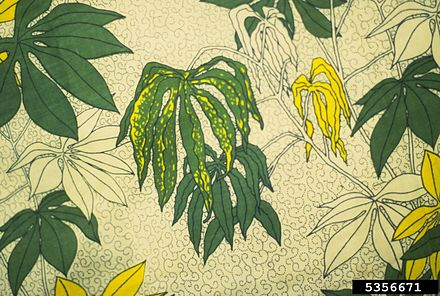
Image credit: https://en.wikipedia.org/wiki/Cassava_mosaic_virus#/media/File:Forestryimages_cassava.jpg

This notebook uses FastAI XLA Extensions Library to use TPU. 
You can learn more about FastAI XLA Extensions Library at https://github.com/butchland/fastai_xla_extensions

I would like to thank Butch Landingin & andreaslillebo for helping me troubeshoot the instalation process.

Let's first install the required libraries 

In [ ]:
%%capture
!pip install -Uqq fastcore --upgrade
!pip install -Uqq fastai --upgrade

Install the TPU client 

In [ ]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

Install fastai_xla_extensions

In [ ]:
!pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

In [ ]:
%%capture
import fastai_xla_extensions.core

In [ ]:
from fastai.vision.all import *


In [ ]:
dataset_path = Path('../input/cassava-leaf-disease-classification')
os.listdir(dataset_path)

Read the CSV file containing file names and labels

In [ ]:
train_df = pd.read_csv(dataset_path/'train.csv')

In [ ]:
train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train_images'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(10)

Resize each image to 224 * 224 and normalize using imagenet stats

In [ ]:
item_tfms = RandomResizedCrop(448, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

In [ ]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               label_col=0, #label is in the first column of the DataFrame
                               fn_col=1, #filename/path is in the second column of the DataFrame
                               bs=bs, #pass in batch size
                               item_tfms=item_tfms, #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

Now let us look at our loaded data.

In [ ]:
dls.show_batch()

          0:"Cassava Bacterial Blight (CBB)",
          1:"Cassava Brown Streak Disease (CBSD)",
          2:"Cassava Green Mottle (CGM)",
          3:"Cassava Mosaic Disease (CMD)",
          4:"Healthy"

We are going to use a very simple model ResNet18 for this demo.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

Transfer the model to TPU.

In [ ]:
learn.to_xla()

In [ ]:
learn.fine_tune(4)

In [ ]:
one_param(learn.model).device

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:

interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(4)

In [ ]:

interp.plot_top_losses(9)